# Training and saving the CNN model

## Load the data and Preprocess the data

In [1]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Normalize the data.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Create ImageDataGenerator objects for data augmentation.
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
generator.fit(x_train)

170498071/170498071 [==============================] - 6s 0us/step


## Build the model

In [2]:
# Set the parameters for the model.
batch_size = 500
num_classes = 10
epochs = 100
init_lr = 0.001

# Set the opimizer
from keras.optimizers import Adam
optimizer = Adam(learning_rate=init_lr)


# Define the model.
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model.
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0

## Train the model

In [6]:
# Set the callbackes
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

from keras.callbacks import LearningRateScheduler
def exponential_decay(epoch, lr):
    decay_rate = 0.95
    decay_steps = epochs
    new_lr = lr * (decay_rate ** (epoch / decay_steps))
    return new_lr
lr_scheduler = LearningRateScheduler(exponential_decay)

history = model.fit(generator.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    validation_steps=len(x_test) / batch_size,
                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/100
100/100 [==============================] - 35s 348ms/step - loss: 1.6086 - accuracy: 0.3980 - val_loss: 3.2418 - val_accuracy: 0.1027 - lr: 9.9897e-04
Epoch 2/100
100/100 [==============================] - 35s 353ms/step - loss: 1.4451 - accuracy: 0.4738 - val_loss: 4.3786 - val_accuracy: 0.1299 - lr: 9.9846e-04
Epoch 3/100
100/100 [==============================] - 36s 357ms/step - loss: 1.3082 - accuracy: 0.5347 - val_loss: 2.5239 - val_accuracy: 0.2634 - lr: 9.9744e-04
Epoch 4/100
100/100 [==============================] - 36s 358ms/step - loss: 1.2121 - accuracy: 0.5713 - val_loss: 1.3681 - val_accuracy: 0.4981 - lr: 9.9591e-04
Epoch 5/100
100/100 [==============================] - 36s 357ms/step - loss: 1.1107 - accuracy: 0.6091 - val_loss: 1.5031 - val_accuracy: 0.5187 - lr: 9.9386e-04
Epoch 6/100
100/100 [==============================] - 35s 352ms/step - loss: 1.0329 - accuracy: 0.6382 - val_loss: 1.1748 - val_accuracy: 0.6032 - lr: 9.9132e-04
Epoch 7/100
100/100 [=

## Evaluate the model

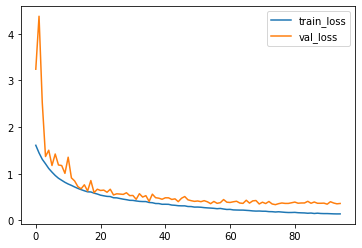

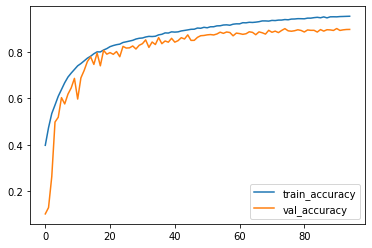

Test loss: 0.3603251278400421
Test accuracy: 0.8967999815940857


In [7]:
# Plot the loss and accuracy curves for training and validation
import matplotlib.pyplot as plt
import numpy as np

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(np.arange(len(train_loss)), train_loss, label='train_loss')
plt.plot(np.arange(len(val_loss)), val_loss, label='val_loss')
plt.legend()
plt.show()

plt.plot(np.arange(len(train_acc)), train_acc, label='train_accuracy')
plt.plot(np.arange(len(val_acc)), val_acc, label='val_accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test data using `evaluate`
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

## Save the model

In [ ]:
from google.colab import files

# save the model
model.save('cifar10_model.h5', include_optimizer=False)
files.download('cifar10_model.h5')